While reading about transformers, I had questions about just how important LayerNorm was. Is it just normalizing the data, or does it change the network in a way similar to a positional encoding? How does it relate to feature representation and (poly)semanticity? Does "folding it in" to the subsequent (previous?) layer in a network make things more or less interpretable? How much better is it than BatchNorm for LLMs, and why? 

While looking at Conjecture's research, I came across this post (https://www.lesswrong.com/posts/jfG6vdJZCwTQmG7kb/re-examining-layernorm), and decided to go through their work to learn more about it. They even have a nice google colab to refer to for more details/ in case I got stuck.

Things I learned: 
-  LayerNorm can be used in place of the activation function  (indeed, it is pretty much a sigmoid activation function with some linear additions)
- The non-linearity can be understood geometrically, making the features fairly interpretable. 
- You can use this newfound geometric understanding to build intuition for more complicated networks with more layers
- How to create better looking plots (with the hope of eventually learning plotly)

First: Understanding the basics about layernorm. The nonlinear bit is just a normalization (sigmoid activation) with mean=0 and var = 1. The learned weights and biases are linear. (The linear bit can probably be folded into the next linear layer, for example). 

Text(0, 0.5, 'Core Nonlinearity of LayerNorm')

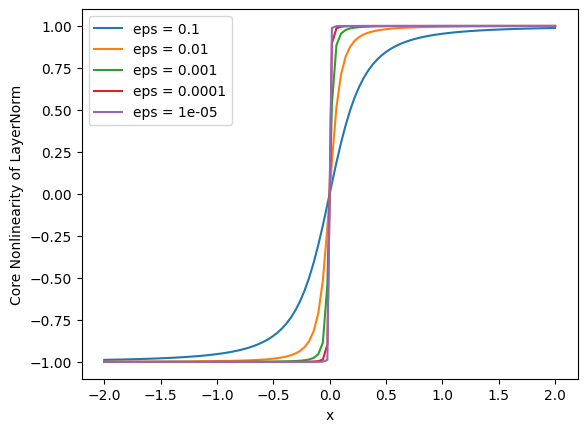

In [1]:
import torch as t
import matplotlib.pyplot as plt
import numpy as np 
from tqdm import tqdm
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def LN_nonlinearity(vec,eps=1e-5):
    sq_norm = t.sum(vec**2, dim = -1,keepdim=True)
    return vec/t.sqrt(sq_norm+eps)

#x is a list of 1 element vectors
x = t.linspace(-2,2,100).unsqueeze(1)
assert x.mean() < 10**-8
epsilons = [10**-i for i in range(1,6)]
for eps in epsilons:
    plt.plot(x, LN_nonlinearity(x,eps) )  
plt.legend([f"eps = {eps}" for eps in epsilons])
plt.xlabel("x")
plt.ylabel("Core Nonlinearity of LayerNorm")

The LayerNorm Activation function: 
- Centering: Subtracting the mean is like projecting out a dimension of the residual stream (why?). This can either be incredibly meaninful (if the gradients are too high) or could be meaningless? 
- A vector has variance 1 if it has length 1/\sqrt(n) (n the length of this vector. mean, variance are taken with respect to EACH vector. This makes sense since each vector has its own residual stream. )

In [2]:
## Affine transformation - Linear part
def affine(x, wts, b):
    return x*wts + b

def layer_norm_1(x, wts, b, eps= 1e-5):
    sub_mean = x - t.mean(x)
    n = x.shape[-1]
    #print(n)
    ## Multiply through with factor of n to rescale x -> sqrt(n0) (var 1)
    return affine(LN_nonlinearity(sub_mean,n*eps), np.sqrt(n)*wts, b)

def layer_norm(x, wts, b, eps=1e-5):
    x_mean = x.mean(dim=-1, keepdim=True)
    ##unbiased=False sets the 1/n convention of pytorch
    x_var = x.var(dim=-1, keepdim=True, unbiased=False)
    print(x.shape, x_var.shape, x_mean.shape)
    x_norm = (x-x_mean)/t.sqrt(x_var + eps)
    return affine(x_norm, wts, b)

### Test this function against pytorch's implementation of LayerNorm 
##### Does a decent job - The error comes from Pytorch's normalization convention (n isntead of n-1)
error = 0 
num_tests = 100
for i in range(num_tests):
    n = t.randint(1,2000, (1,)).item()
    x = t.rand(n)
    wts = t.rand(n)
    b = t.rand(n)
    eps = t.rand(1).item()
    assert x.shape == b.shape
    out = layer_norm_1(x, wts, b, eps)
    out_torch = t.nn.functional.layer_norm(x,(n,), wts, b, eps)
    error += t.linalg.vector_norm(out - out_torch, ord = 1).item()
print(f"error for warm-up LN implementation = {error/num_tests}")

for i in range(num_tests):
    n = t.randint(1,2000, (1,)).item()
    x = t.rand(n)
    wts = t.rand(n)
    b = t.rand(n)
    eps = t.rand(1).item()
    assert x.shape == b.shape
    out = layer_norm(x, wts, b, eps)
    out_torch = t.nn.functional.layer_norm(x,(n,), wts, b, eps)
    error += t.linalg.vector_norm(out - out_torch, ord = 1).item()
print(f"error for better LN implementation = {error/num_tests}")

## ... they are exactly the same! Why? 

error for warm-up LN implementation = 2.728888182900846e-05
torch.Size([37]) torch.Size([1]) torch.Size([1])
torch.Size([1913]) torch.Size([1]) torch.Size([1])
torch.Size([909]) torch.Size([1]) torch.Size([1])
torch.Size([709]) torch.Size([1]) torch.Size([1])
torch.Size([1194]) torch.Size([1]) torch.Size([1])
torch.Size([13]) torch.Size([1]) torch.Size([1])
torch.Size([1094]) torch.Size([1]) torch.Size([1])
torch.Size([1863]) torch.Size([1]) torch.Size([1])
torch.Size([7]) torch.Size([1]) torch.Size([1])
torch.Size([408]) torch.Size([1]) torch.Size([1])
torch.Size([1251]) torch.Size([1]) torch.Size([1])
torch.Size([459]) torch.Size([1]) torch.Size([1])
torch.Size([1246]) torch.Size([1]) torch.Size([1])
torch.Size([469]) torch.Size([1]) torch.Size([1])
torch.Size([990]) torch.Size([1]) torch.Size([1])
torch.Size([493]) torch.Size([1]) torch.Size([1])
torch.Size([648]) torch.Size([1]) torch.Size([1])
torch.Size([1455]) torch.Size([1]) torch.Size([1])
torch.Size([610]) torch.Size([1]) tor

Stretching and Folding: Understanding the geometric consequences of acting with the LayerNorm activation function 
- The activation is typically composed with affine transformations, which apply rotations, stretching (scaling) and translations. 
- Is this really understanding the nonlinearity, or just the linear part? Yes, since you see what happens to simple transformations as they pass through the non-linearity ... they are normalized so that there distribution changes in a predictable way 

One-dimensional stretch 
- compose the nonlinear LN activation with a simple scaling x -> alpha x
- plt this on an input data set that is S^1


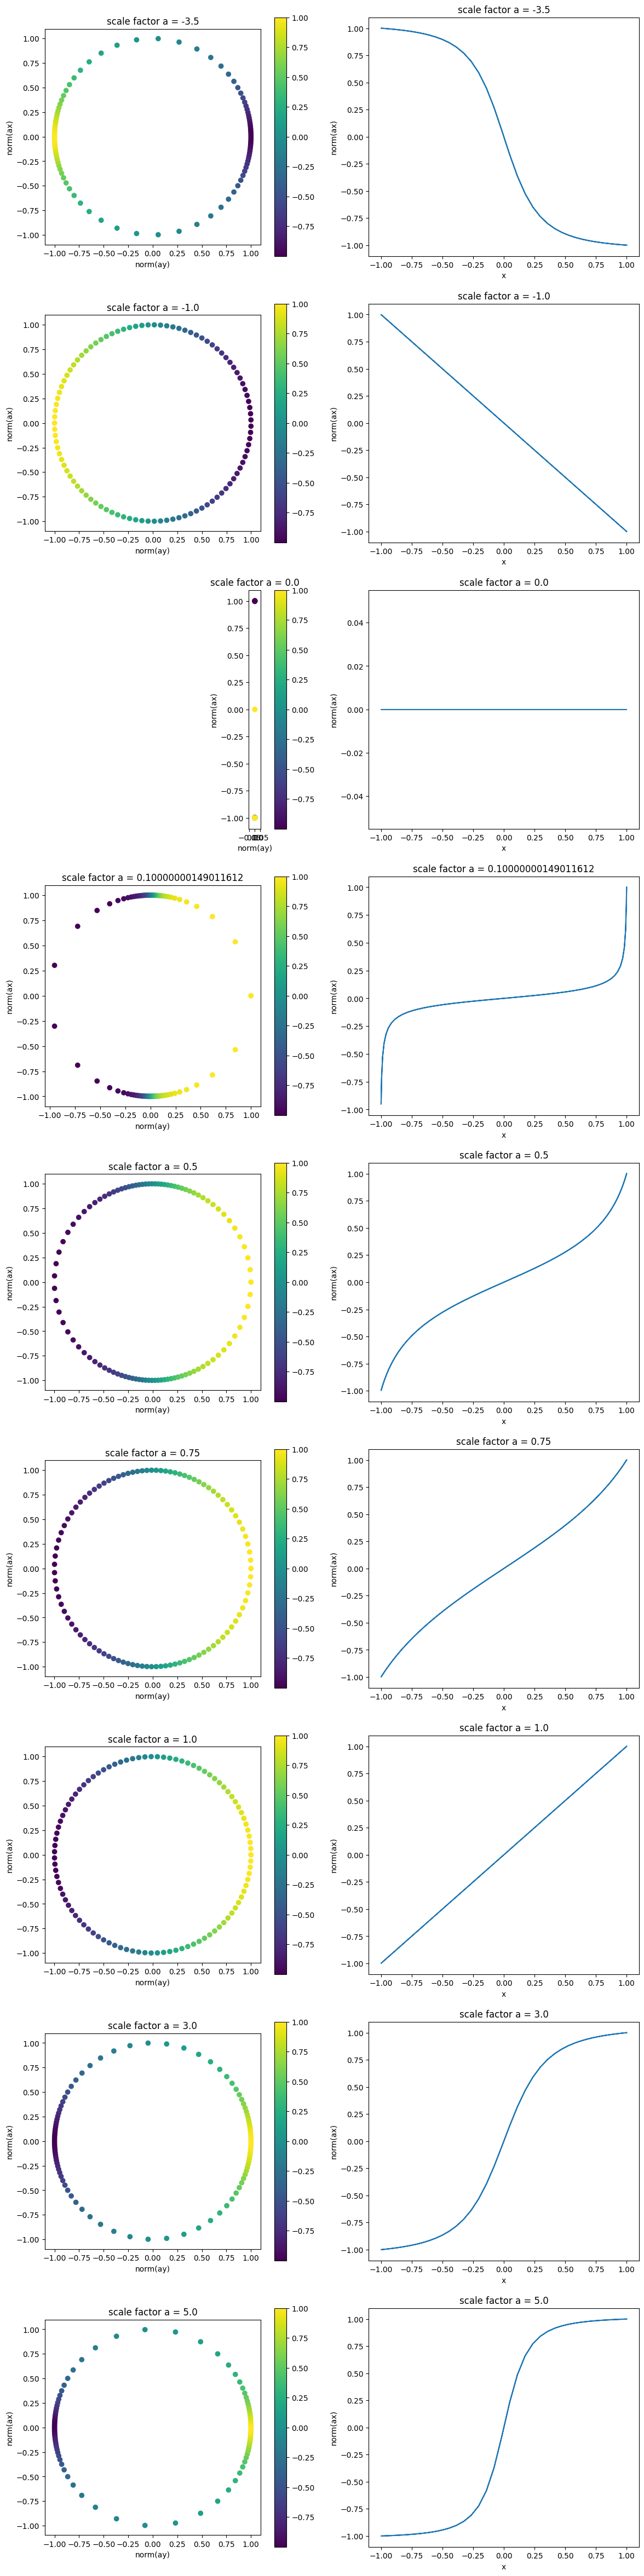

In [3]:
#number of data points 
n_points = 100

# #
def uniform_circle_data(n):
    theta = t.linspace(0,2*t.pi, n)
    return t.stack((t.cos(theta), t.sin(theta)), dim=1)

data = uniform_circle_data(n_points).unsqueeze(0)

# Use the default value for eps
### Apply transformation to only x dimension
#### normalization via LN_nonlinearity should keep all points on unit circle


def warp(data, scale, trans, eps=1e-5):
    transformed_data = (t.FloatTensor([scale,1])*data.squeeze() + t.FloatTensor([trans,0])).unsqueeze(0)
    return LN_nonlinearity(transformed_data)
scalings = t.tensor([-2. -1.5, -1, 0,.1, .5, .75,1., 3, 5])

fig, ax = plt.subplots(len(scalings),2, figsize=(14,60))
for i, scale in enumerate(scalings):
    stretch_func = warp(data, scale,0).squeeze()
    test = ax[i][0].scatter(stretch_func[:,0], stretch_func[:,1], c=data.squeeze()[...,0])
    ax[i][0].set_aspect('equal')
    ax[i][1].plot(data[0,:,0],stretch_func[:,0])
    ax[i][0].set_title(f"scale factor a = {scale}")
    ax[i][1].set_title(f"scale factor a = {scale}")
    ax[i][0].set(xlabel="norm(ay)", ylabel = "norm(ax)")
    ax[i][1].set(xlabel="x", ylabel = "norm(ax)")
    fig.colorbar(test)




In [408]:

### notes: As expected, a negative value of the scaling flips the orientation of the circle, but keeps the density of points the same. For a scaling less than one, the points accummulate at the poles of the circle, since the scaled points get closer to 0 as the scaling is decreased. The norm becomes more singlar for extremal values of x, resembling a sigmoid rotated 90 degrees, though it is of course 0 for a = 0. 
### For values of abs(a) >1, the extremal points get farther away from each other, and the points cluster at the sides. The norm resembles a sigmoid. 

Folding: 1d folding

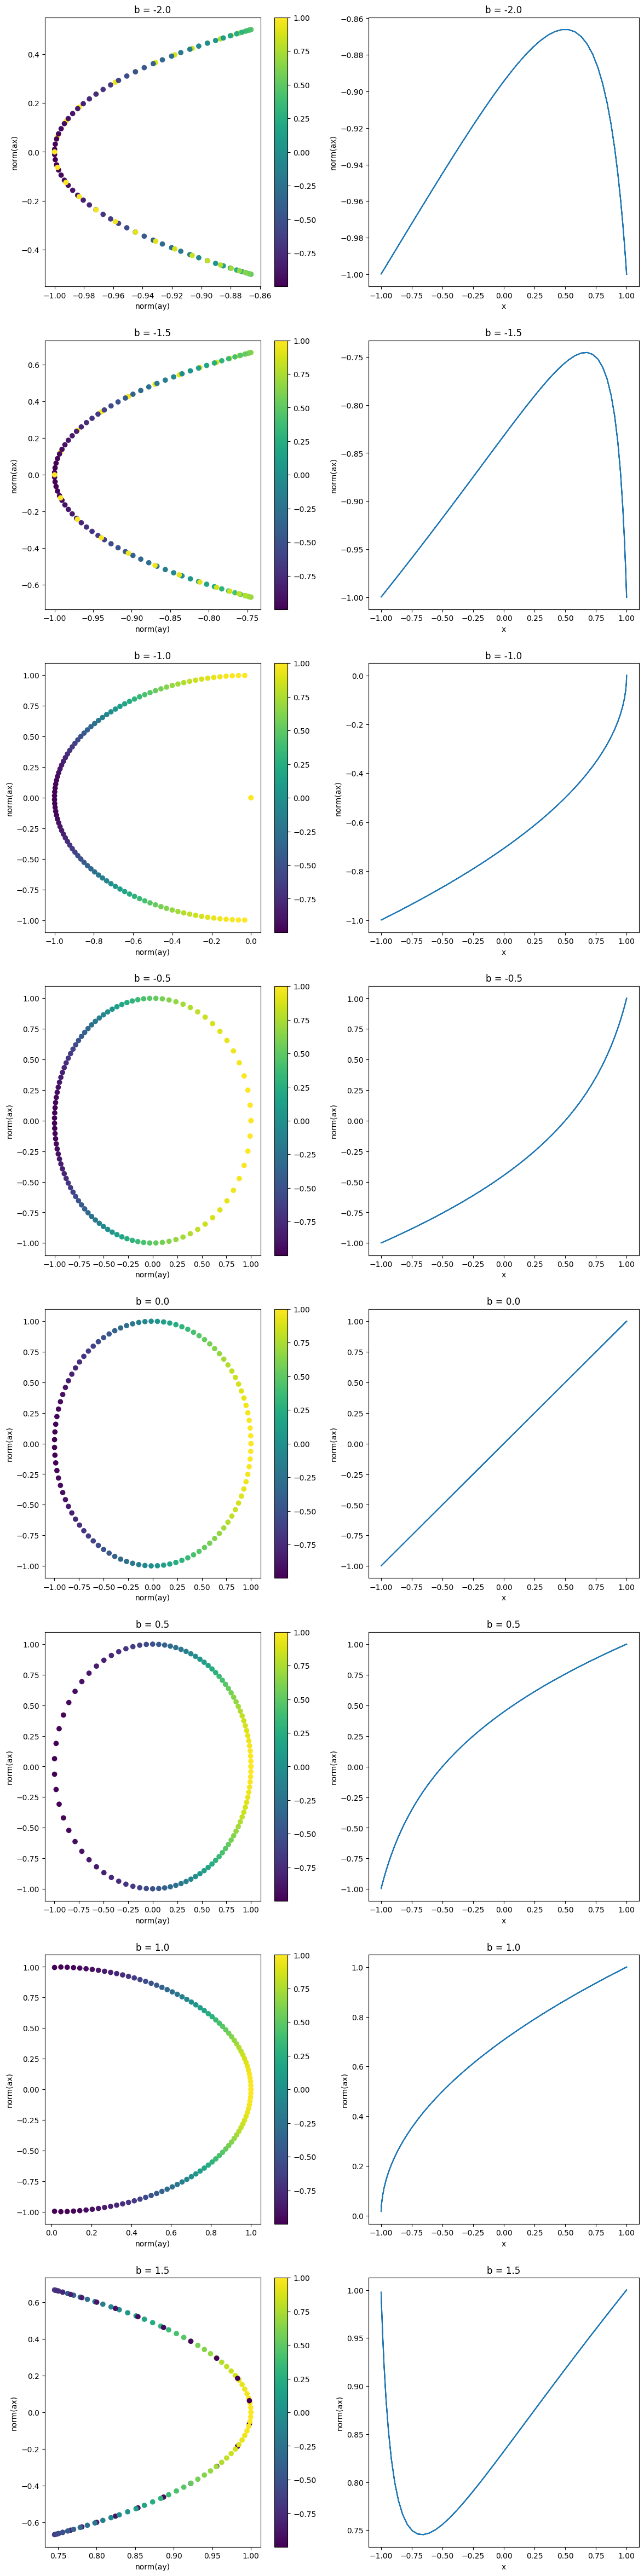

In [7]:
translations = t.arange(-2,2,.5)
fig, ax = plt.subplots(len(translations),2, figsize=(14,60))
for i, trans in enumerate(translations):
    fold_func = warp(data, 1,trans).squeeze()
    test = ax[i][0].scatter(fold_func[:,0], fold_func[:,1], c=data.squeeze()[...,0])
    #ax[i][0].set_aspect('equal')
    ax[i][1].plot(data[0,:,0],fold_func[:,0])
    ax[i][0].set_title(f"b = {trans}")
    ax[i][1].set_title(f"b = {trans}")
    ax[i][0].set(xlabel="norm(ay)", ylabel = "norm(ax)")
    ax[i][1].set(xlabel="x", ylabel = "norm(ax)")
    fig.colorbar(test)